In [1]:
import torch
import torch.nn as nn
import torchvision
from fld.features.InceptionFeatureExtractor import InceptionFeatureExtractor
from fld.metrics.FLD import FLD
from fld.metrics.FID import FID
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

from fld.features.DINOv2FeatureExtractor import DINOv2FeatureExtractor
from fld.features.InceptionFeatureExtractor import InceptionFeatureExtractor
from fld.features.CLIPFeatureExtractor import CLIPFeatureExtractor
from fld.metrics.FLD import FLD
from fld.metrics.FID import FID

In [2]:
import torch
print(torch.cuda.is_available())  #  return True if CUDA is enabled
print(torch.version.cuda)  #  show the CUDA version PyTorch was compiled with
print(torch.cuda.device_count())  # Number of available GPUs
print(torch.cuda.get_device_name(0))  # Name of your GPU (if available)


True
12.1
1
NVIDIA GeForce RTX 3060 Laptop GPU


In [3]:
# ----------------------
# Step 4: Load Datasets (CIFAR-10)
# ----------------------

train_dataset = torchvision.datasets.CIFAR10(root=r"D:\ift6164\data", train=True, download=True)
train_dataset.name = "CIFAR10_train"  # Dataset needs a name to cache features

test_dataset = torchvision.datasets.CIFAR10(root=r"D:\ift6164\data", train=False, download=True)
test_dataset.name = "CIFAR10_test"


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# ----------------------
# Step 4: Load GENERATED Datasets (CIFAR)
# ----------------------

# Path to generated CIFAR-10 images
generated_images_path = "D:/ift6164/gen_data/ckpt_pgfmpp"
# Load generated CIFAR-10 dataset 
generated_dataset = ImageFolder(root=generated_images_path)
generated_dataset.name = "Generated_pgfmpp_CIFAR10"

In [5]:
len(generated_dataset)

10089

In [6]:
feature_extractor_D = DINOv2FeatureExtractor()

Using cache found in C:\Users\oumni/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\oumni/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\oumni/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\oumni/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [54]:
## define minor transformations
def apply_gaussian_blur(img):
    """Apply a minor Gaussian Blur"""
    return transforms.GaussianBlur(kernel_size=1, sigma=(0.01, 0.02))(img)

def apply_posterize(img):
    """Reduce color depth to simulate posterization"""
    return transforms.functional.posterize(img, bits=7)

def apply_jpeg_compression(img, quality=98):
    """Save and reload image with JPEG compression"""
    img_pil = img.convert("RGB")  # Convert to RGB mode if needed
    img_pil.save("temp.jpg", "JPEG", quality=quality, optimize=True)
    return Image.open("temp.jpg").convert("RGB")


## define  major transformations
def apply_color_distortion(img):
    """Randomly adjust brightness, contrast, saturation, and hue"""
    return transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)(img)

def apply_center_crop(img):
    """Crop the center region of the image"""
    #return transforms.CenterCrop(size=(img.size[0] // 2, img.size[1] // 2))(img)
    return transforms.CenterCrop(size=(img.size[0] * 3 // 4, img.size[1] * 3 // 4))(img)

def apply_elastic_transform(img):
    """Apply elastic deformation (requires torchvision >= 0.11.0)"""
    return transforms.ElasticTransform(alpha=25.0)(img)

def apply_heavy_blur(img):
    """Apply a strong Gaussian blur"""
    return transforms.GaussianBlur(kernel_size=7, sigma=(2.5, 5.0))(img)

# Define the transformation dictionary
minor_transforms = {
    "Gaussian Blur": apply_gaussian_blur,
    "Posterize": apply_posterize,
    "JPG Compression": apply_jpeg_compression
}

major_transforms = {
    "Color Distortion": apply_color_distortion,
    "Center Crop": apply_center_crop,
    "Elastic Transform": apply_elastic_transform,
    "Heavy Blur": apply_heavy_blur
}


# Function to apply transformations to a dataset
def apply_transformations(dataset, transform_dict):
    transformed_datasets = {}
    for name, transform in transform_dict.items():
        #transformed_datasets[name] = [transform(img) for img in dataset]
        transformed_datasets[name] = [transform(img[0] if isinstance(img, tuple) else img) for img in dataset]
    return transformed_datasets



In [ ]:
# Apply transformations to CIFAR-10 test dataset
minor_transformed_images = apply_transformations(generated_dataset, minor_transforms)

In [55]:
major_transformed_images = apply_transformations(generated_dataset, major_transforms)

In [9]:
train_feat_D = feature_extractor_D.get_dataset_features(train_dataset)

In [10]:
test_feat_D = feature_extractor_D.get_dataset_features(test_dataset)

In [11]:
gen_feat_D1 = feature_extractor_D.get_dataset_features(generated_dataset) 

In [12]:
gen_feat_D2 = feature_extractor_D.get_dir_features(generated_images_path,extension="png") 

In [13]:
fld_metric = FLD()
fid_metric = FID()

In [14]:
fid_original_D1 = fid_metric.compute_metric(train_feat_D, None, gen_feat_D1)

In [15]:
fld_original_D1 = fld_metric.compute_metric(train_feat_D, test_feat_D, gen_feat_D1)

In [16]:
fid_original_D2 = fid_metric.compute_metric(train_feat_D, None, gen_feat_D2)

In [17]:
fld_original_D2 = fld_metric.compute_metric(train_feat_D, test_feat_D, gen_feat_D2)

In [19]:
print(fid_original_D1)
print(fid_original_D2)

print("----")

print(fld_original_D1)
print(fld_original_D2)

113.96717453247811
113.96722990819808
----
4.7077178955078125
4.766225814819336


In [32]:
fid_original_D1 = 113.96717453247811
fid_original_D2 = 113.96722990819808

fld_original_D1 = 4.7077178955078125
fld_original_D2 = 4.766225814819336

In [56]:
# Minimal dataset wrapper for transformed images
class TransformedDataset(Dataset):
    def __init__(self, images):
        self.images = images  # List of images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], 0  # Dummy label

# Extract features for each transformed dataset
def extract_features(transformed_datasets):
    return {name: feature_extractor_D.get_dataset_features(TransformedDataset(images))
            for name, images in transformed_datasets.items()}
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch
import numpy as np
import torchvision.transforms as transforms


DINO_INPUT_SIZE = 224

# Minimal dataset wrapper for transformed images
class TransformedDataset(Dataset):
    def __init__(self, images):
        self.transform = transforms.Compose([
            transforms.Resize((DINO_INPUT_SIZE, DINO_INPUT_SIZE)),  # Resize to match model
            transforms.ToTensor()  # Convert to tensor
        ])
        self.images = [self.transform(img) for img in images]  # Apply transformations

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], 0  # Return (image, dummy label) tuple

# Function to extract features with batch processing and resizing
def extract_features(transformed_datasets, feature_extractor, batch_size=32):
    transformed_features = {}

    for name, images in transformed_datasets.items():
        print(f"\n[INFO] Extracting features for: {name} ({len(images)} images)")

        dataset = TransformedDataset(images)  # Convert image list to dataset
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

        features_list = []
        
        for batch_idx, (img_batch, _) in enumerate(tqdm(dataloader, desc=f"Processing {name}", leave=True)):
            img_batch = img_batch.to("cuda" if torch.cuda.is_available() else "cpu")  # Move to GPU if available
            
            # Extract features for the batch
            batch_features = feature_extractor.get_feature_batch(img_batch)
            features_list.append(batch_features.cpu().numpy())

            # Print progress every 10 batches
            if batch_idx % 10 == 0:
                print(f" - Processed {batch_idx * batch_size}/{len(images)} images for {name}")

        # Combine all batches into a single feature matrix
        transformed_features[name] = np.vstack(features_list)

    return transformed_features



In [41]:
# Extract features for minor and major transformations with tracking
minor_feats_D = extract_features(minor_transformed_images, feature_extractor_D, batch_size=32)


[INFO] Extracting features for: Gaussian Blur (10089 images)


Processing Gaussian Blur:   0%|          | 1/316 [00:01<06:49,  1.30s/it]

 - Processed 0/10089 images for Gaussian Blur


Processing Gaussian Blur:   3%|▎         | 11/316 [00:07<02:58,  1.71it/s]

 - Processed 320/10089 images for Gaussian Blur


Processing Gaussian Blur:   7%|▋         | 21/316 [00:13<02:56,  1.68it/s]

 - Processed 640/10089 images for Gaussian Blur


Processing Gaussian Blur:  10%|▉         | 31/316 [00:18<02:48,  1.69it/s]

 - Processed 960/10089 images for Gaussian Blur


Processing Gaussian Blur:  13%|█▎        | 41/316 [00:24<02:41,  1.70it/s]

 - Processed 1280/10089 images for Gaussian Blur


Processing Gaussian Blur:  16%|█▌        | 51/316 [00:30<02:44,  1.61it/s]

 - Processed 1600/10089 images for Gaussian Blur


Processing Gaussian Blur:  19%|█▉        | 61/316 [00:37<03:18,  1.28it/s]

 - Processed 1920/10089 images for Gaussian Blur


Processing Gaussian Blur:  22%|██▏       | 71/316 [00:43<02:22,  1.71it/s]

 - Processed 2240/10089 images for Gaussian Blur


Processing Gaussian Blur:  26%|██▌       | 81/316 [00:49<02:25,  1.62it/s]

 - Processed 2560/10089 images for Gaussian Blur


Processing Gaussian Blur:  29%|██▉       | 91/316 [00:56<02:16,  1.65it/s]

 - Processed 2880/10089 images for Gaussian Blur


Processing Gaussian Blur:  32%|███▏      | 101/316 [01:02<02:22,  1.51it/s]

 - Processed 3200/10089 images for Gaussian Blur


Processing Gaussian Blur:  35%|███▌      | 111/316 [01:08<02:12,  1.55it/s]

 - Processed 3520/10089 images for Gaussian Blur


Processing Gaussian Blur:  38%|███▊      | 121/316 [01:14<02:00,  1.62it/s]

 - Processed 3840/10089 images for Gaussian Blur


Processing Gaussian Blur:  41%|████▏     | 131/316 [01:21<01:57,  1.58it/s]

 - Processed 4160/10089 images for Gaussian Blur


Processing Gaussian Blur:  45%|████▍     | 141/316 [01:27<01:49,  1.60it/s]

 - Processed 4480/10089 images for Gaussian Blur


Processing Gaussian Blur:  48%|████▊     | 151/316 [01:33<01:45,  1.57it/s]

 - Processed 4800/10089 images for Gaussian Blur


Processing Gaussian Blur:  51%|█████     | 161/316 [01:39<01:32,  1.68it/s]

 - Processed 5120/10089 images for Gaussian Blur


Processing Gaussian Blur:  54%|█████▍    | 171/316 [01:45<01:28,  1.64it/s]

 - Processed 5440/10089 images for Gaussian Blur


Processing Gaussian Blur:  57%|█████▋    | 181/316 [01:51<01:24,  1.60it/s]

 - Processed 5760/10089 images for Gaussian Blur


Processing Gaussian Blur:  60%|██████    | 191/316 [01:58<01:18,  1.59it/s]

 - Processed 6080/10089 images for Gaussian Blur


Processing Gaussian Blur:  64%|██████▎   | 201/316 [02:04<01:07,  1.70it/s]

 - Processed 6400/10089 images for Gaussian Blur


Processing Gaussian Blur:  67%|██████▋   | 211/316 [02:10<01:02,  1.67it/s]

 - Processed 6720/10089 images for Gaussian Blur


Processing Gaussian Blur:  70%|██████▉   | 221/316 [02:15<00:55,  1.71it/s]

 - Processed 7040/10089 images for Gaussian Blur


Processing Gaussian Blur:  73%|███████▎  | 231/316 [02:21<00:48,  1.74it/s]

 - Processed 7360/10089 images for Gaussian Blur


Processing Gaussian Blur:  76%|███████▋  | 241/316 [02:27<00:44,  1.70it/s]

 - Processed 7680/10089 images for Gaussian Blur


Processing Gaussian Blur:  79%|███████▉  | 251/316 [02:33<00:40,  1.61it/s]

 - Processed 8000/10089 images for Gaussian Blur


Processing Gaussian Blur:  83%|████████▎ | 261/316 [02:39<00:28,  1.95it/s]

 - Processed 8320/10089 images for Gaussian Blur


Processing Gaussian Blur:  86%|████████▌ | 271/316 [02:44<00:22,  1.98it/s]

 - Processed 8640/10089 images for Gaussian Blur


Processing Gaussian Blur:  89%|████████▉ | 281/316 [02:50<00:20,  1.75it/s]

 - Processed 8960/10089 images for Gaussian Blur


Processing Gaussian Blur:  92%|█████████▏| 291/316 [02:56<00:13,  1.85it/s]

 - Processed 9280/10089 images for Gaussian Blur


Processing Gaussian Blur:  95%|█████████▌| 301/316 [03:01<00:07,  2.05it/s]

 - Processed 9600/10089 images for Gaussian Blur


Processing Gaussian Blur:  98%|█████████▊| 311/316 [03:05<00:02,  2.11it/s]

 - Processed 9920/10089 images for Gaussian Blur


Processing Gaussian Blur: 100%|██████████| 316/316 [03:07<00:00,  1.68it/s]



[INFO] Extracting features for: Posterize (10089 images)


Processing Posterize:   0%|          | 1/316 [00:00<04:26,  1.18it/s]

 - Processed 0/10089 images for Posterize


Processing Posterize:   3%|▎         | 11/316 [00:05<02:18,  2.20it/s]

 - Processed 320/10089 images for Posterize


Processing Posterize:   7%|▋         | 21/316 [00:09<01:44,  2.81it/s]

 - Processed 640/10089 images for Posterize


Processing Posterize:  10%|▉         | 31/316 [00:12<01:35,  3.00it/s]

 - Processed 960/10089 images for Posterize


Processing Posterize:  13%|█▎        | 41/316 [00:16<01:28,  3.10it/s]

 - Processed 1280/10089 images for Posterize


Processing Posterize:  16%|█▌        | 51/316 [00:21<02:18,  1.91it/s]

 - Processed 1600/10089 images for Posterize


Processing Posterize:  19%|█▉        | 61/316 [00:26<02:27,  1.72it/s]

 - Processed 1920/10089 images for Posterize


Processing Posterize:  22%|██▏       | 71/316 [00:32<02:13,  1.83it/s]

 - Processed 2240/10089 images for Posterize


Processing Posterize:  26%|██▌       | 81/316 [00:37<02:11,  1.79it/s]

 - Processed 2560/10089 images for Posterize


Processing Posterize:  29%|██▉       | 91/316 [00:49<04:30,  1.20s/it]

 - Processed 2880/10089 images for Posterize


Processing Posterize:  32%|███▏      | 101/316 [00:58<02:35,  1.38it/s]

 - Processed 3200/10089 images for Posterize


Processing Posterize:  35%|███▌      | 111/316 [01:03<01:52,  1.83it/s]

 - Processed 3520/10089 images for Posterize


Processing Posterize:  38%|███▊      | 121/316 [01:08<01:36,  2.03it/s]

 - Processed 3840/10089 images for Posterize


Processing Posterize:  41%|████▏     | 131/316 [01:15<03:15,  1.06s/it]

 - Processed 4160/10089 images for Posterize


Processing Posterize:  45%|████▍     | 141/316 [01:22<01:48,  1.61it/s]

 - Processed 4480/10089 images for Posterize


Processing Posterize:  48%|████▊     | 151/316 [01:28<02:03,  1.34it/s]

 - Processed 4800/10089 images for Posterize


Processing Posterize:  51%|█████     | 161/316 [01:34<01:24,  1.83it/s]

 - Processed 5120/10089 images for Posterize


Processing Posterize:  54%|█████▍    | 171/316 [01:40<01:19,  1.83it/s]

 - Processed 5440/10089 images for Posterize


Processing Posterize:  57%|█████▋    | 181/316 [01:47<01:45,  1.28it/s]

 - Processed 5760/10089 images for Posterize


Processing Posterize:  60%|██████    | 191/316 [01:53<01:08,  1.82it/s]

 - Processed 6080/10089 images for Posterize


Processing Posterize:  64%|██████▎   | 201/316 [02:00<01:38,  1.17it/s]

 - Processed 6400/10089 images for Posterize


Processing Posterize:  67%|██████▋   | 211/316 [02:19<02:52,  1.64s/it]

 - Processed 6720/10089 images for Posterize


Processing Posterize:  70%|██████▉   | 221/316 [02:24<00:53,  1.76it/s]

 - Processed 7040/10089 images for Posterize


Processing Posterize:  73%|███████▎  | 231/316 [02:29<00:44,  1.89it/s]

 - Processed 7360/10089 images for Posterize


Processing Posterize:  76%|███████▋  | 241/316 [02:35<00:39,  1.92it/s]

 - Processed 7680/10089 images for Posterize


Processing Posterize:  79%|███████▉  | 251/316 [02:40<00:35,  1.83it/s]

 - Processed 8000/10089 images for Posterize


Processing Posterize:  83%|████████▎ | 261/316 [02:45<00:30,  1.80it/s]

 - Processed 8320/10089 images for Posterize


Processing Posterize:  86%|████████▌ | 271/316 [02:51<00:25,  1.80it/s]

 - Processed 8640/10089 images for Posterize


Processing Posterize:  89%|████████▉ | 281/316 [02:57<00:19,  1.80it/s]

 - Processed 8960/10089 images for Posterize


Processing Posterize:  92%|█████████▏| 291/316 [03:02<00:13,  1.81it/s]

 - Processed 9280/10089 images for Posterize


Processing Posterize:  95%|█████████▌| 301/316 [03:08<00:08,  1.79it/s]

 - Processed 9600/10089 images for Posterize


Processing Posterize:  98%|█████████▊| 311/316 [03:13<00:02,  1.80it/s]

 - Processed 9920/10089 images for Posterize


Processing Posterize: 100%|██████████| 316/316 [03:16<00:00,  1.61it/s]



[INFO] Extracting features for: JPG Compression (10089 images)


Processing JPG Compression:   0%|          | 1/316 [00:01<06:00,  1.15s/it]

 - Processed 0/10089 images for JPG Compression


Processing JPG Compression:   3%|▎         | 11/316 [00:10<03:21,  1.52it/s]

 - Processed 320/10089 images for JPG Compression


Processing JPG Compression:   7%|▋         | 21/316 [00:15<02:23,  2.05it/s]

 - Processed 640/10089 images for JPG Compression


Processing JPG Compression:  10%|▉         | 31/316 [00:20<01:59,  2.38it/s]

 - Processed 960/10089 images for JPG Compression


Processing JPG Compression:  13%|█▎        | 41/316 [00:23<01:40,  2.73it/s]

 - Processed 1280/10089 images for JPG Compression


Processing JPG Compression:  16%|█▌        | 51/316 [00:28<02:26,  1.81it/s]

 - Processed 1600/10089 images for JPG Compression


Processing JPG Compression:  19%|█▉        | 61/316 [00:34<02:00,  2.12it/s]

 - Processed 1920/10089 images for JPG Compression


Processing JPG Compression:  22%|██▏       | 71/316 [00:38<01:40,  2.44it/s]

 - Processed 2240/10089 images for JPG Compression


Processing JPG Compression:  26%|██▌       | 81/316 [00:42<02:01,  1.94it/s]

 - Processed 2560/10089 images for JPG Compression


Processing JPG Compression:  29%|██▉       | 91/316 [00:48<01:57,  1.92it/s]

 - Processed 2880/10089 images for JPG Compression


Processing JPG Compression:  32%|███▏      | 101/316 [00:53<01:55,  1.86it/s]

 - Processed 3200/10089 images for JPG Compression


Processing JPG Compression:  35%|███▌      | 111/316 [00:59<01:46,  1.92it/s]

 - Processed 3520/10089 images for JPG Compression


Processing JPG Compression:  38%|███▊      | 121/316 [01:04<01:39,  1.96it/s]

 - Processed 3840/10089 images for JPG Compression


Processing JPG Compression:  41%|████▏     | 131/316 [01:09<01:32,  2.00it/s]

 - Processed 4160/10089 images for JPG Compression


Processing JPG Compression:  45%|████▍     | 141/316 [01:13<01:02,  2.80it/s]

 - Processed 4480/10089 images for JPG Compression


Processing JPG Compression:  48%|████▊     | 151/316 [01:16<01:08,  2.41it/s]

 - Processed 4800/10089 images for JPG Compression


Processing JPG Compression:  51%|█████     | 161/316 [01:21<01:07,  2.28it/s]

 - Processed 5120/10089 images for JPG Compression


Processing JPG Compression:  54%|█████▍    | 171/316 [01:25<00:56,  2.59it/s]

 - Processed 5440/10089 images for JPG Compression


Processing JPG Compression:  57%|█████▋    | 181/316 [01:29<00:51,  2.62it/s]

 - Processed 5760/10089 images for JPG Compression


Processing JPG Compression:  60%|██████    | 191/316 [01:34<01:04,  1.92it/s]

 - Processed 6080/10089 images for JPG Compression


Processing JPG Compression:  64%|██████▎   | 201/316 [01:39<00:59,  1.94it/s]

 - Processed 6400/10089 images for JPG Compression


Processing JPG Compression:  67%|██████▋   | 211/316 [01:44<00:54,  1.92it/s]

 - Processed 6720/10089 images for JPG Compression


Processing JPG Compression:  70%|██████▉   | 221/316 [01:49<00:38,  2.45it/s]

 - Processed 7040/10089 images for JPG Compression


Processing JPG Compression:  73%|███████▎  | 231/316 [01:53<00:33,  2.52it/s]

 - Processed 7360/10089 images for JPG Compression


Processing JPG Compression:  76%|███████▋  | 241/316 [01:56<00:29,  2.54it/s]

 - Processed 7680/10089 images for JPG Compression


Processing JPG Compression:  79%|███████▉  | 251/316 [02:01<00:26,  2.49it/s]

 - Processed 8000/10089 images for JPG Compression


Processing JPG Compression:  83%|████████▎ | 261/316 [02:05<00:28,  1.96it/s]

 - Processed 8320/10089 images for JPG Compression


Processing JPG Compression:  86%|████████▌ | 271/316 [02:09<00:18,  2.49it/s]

 - Processed 8640/10089 images for JPG Compression


Processing JPG Compression:  89%|████████▉ | 281/316 [02:13<00:14,  2.49it/s]

 - Processed 8960/10089 images for JPG Compression


Processing JPG Compression:  92%|█████████▏| 291/316 [02:18<00:10,  2.48it/s]

 - Processed 9280/10089 images for JPG Compression


Processing JPG Compression:  95%|█████████▌| 301/316 [02:22<00:06,  2.47it/s]

 - Processed 9600/10089 images for JPG Compression


Processing JPG Compression:  98%|█████████▊| 311/316 [02:26<00:02,  2.34it/s]

 - Processed 9920/10089 images for JPG Compression


Processing JPG Compression: 100%|██████████| 316/316 [02:28<00:00,  2.13it/s]


In [57]:
major_feats_D = extract_features(major_transformed_images, feature_extractor_D, batch_size=32)


[INFO] Extracting features for: Color Distortion (10089 images)


Processing Color Distortion:   0%|          | 1/316 [00:00<05:13,  1.00it/s]

 - Processed 0/10089 images for Color Distortion


Processing Color Distortion:   3%|▎         | 11/316 [00:06<02:35,  1.96it/s]

 - Processed 320/10089 images for Color Distortion


Processing Color Distortion:   7%|▋         | 21/316 [00:10<01:47,  2.75it/s]

 - Processed 640/10089 images for Color Distortion


Processing Color Distortion:  10%|▉         | 31/316 [00:13<01:36,  2.96it/s]

 - Processed 960/10089 images for Color Distortion


Processing Color Distortion:  13%|█▎        | 41/316 [00:16<01:30,  3.05it/s]

 - Processed 1280/10089 images for Color Distortion


Processing Color Distortion:  16%|█▌        | 51/316 [00:20<01:28,  3.00it/s]

 - Processed 1600/10089 images for Color Distortion


Processing Color Distortion:  19%|█▉        | 61/316 [00:23<01:23,  3.04it/s]

 - Processed 1920/10089 images for Color Distortion


Processing Color Distortion:  22%|██▏       | 71/316 [00:26<01:22,  2.98it/s]

 - Processed 2240/10089 images for Color Distortion


Processing Color Distortion:  26%|██▌       | 81/316 [00:30<01:16,  3.07it/s]

 - Processed 2560/10089 images for Color Distortion


Processing Color Distortion:  29%|██▉       | 91/316 [00:33<01:13,  3.07it/s]

 - Processed 2880/10089 images for Color Distortion


Processing Color Distortion:  32%|███▏      | 101/316 [00:36<01:10,  3.05it/s]

 - Processed 3200/10089 images for Color Distortion


Processing Color Distortion:  35%|███▌      | 111/316 [00:40<01:07,  3.02it/s]

 - Processed 3520/10089 images for Color Distortion


Processing Color Distortion:  38%|███▊      | 121/316 [00:43<01:04,  3.02it/s]

 - Processed 3840/10089 images for Color Distortion


Processing Color Distortion:  41%|████▏     | 131/316 [00:46<01:01,  3.02it/s]

 - Processed 4160/10089 images for Color Distortion


Processing Color Distortion:  45%|████▍     | 141/316 [00:50<00:58,  3.00it/s]

 - Processed 4480/10089 images for Color Distortion


Processing Color Distortion:  48%|████▊     | 151/316 [00:53<00:55,  2.95it/s]

 - Processed 4800/10089 images for Color Distortion


Processing Color Distortion:  51%|█████     | 161/316 [00:56<00:56,  2.74it/s]

 - Processed 5120/10089 images for Color Distortion


Processing Color Distortion:  54%|█████▍    | 171/316 [01:00<00:50,  2.88it/s]

 - Processed 5440/10089 images for Color Distortion


Processing Color Distortion:  57%|█████▋    | 181/316 [01:03<00:46,  2.91it/s]

 - Processed 5760/10089 images for Color Distortion


Processing Color Distortion:  60%|██████    | 191/316 [01:07<00:44,  2.84it/s]

 - Processed 6080/10089 images for Color Distortion


Processing Color Distortion:  64%|██████▎   | 201/316 [01:11<00:40,  2.82it/s]

 - Processed 6400/10089 images for Color Distortion


Processing Color Distortion:  67%|██████▋   | 211/316 [01:14<00:37,  2.80it/s]

 - Processed 6720/10089 images for Color Distortion


Processing Color Distortion:  70%|██████▉   | 221/316 [01:18<00:34,  2.75it/s]

 - Processed 7040/10089 images for Color Distortion


Processing Color Distortion:  73%|███████▎  | 231/316 [01:21<00:30,  2.79it/s]

 - Processed 7360/10089 images for Color Distortion


Processing Color Distortion:  76%|███████▋  | 241/316 [01:25<00:27,  2.73it/s]

 - Processed 7680/10089 images for Color Distortion


Processing Color Distortion:  79%|███████▉  | 251/316 [01:29<00:24,  2.70it/s]

 - Processed 8000/10089 images for Color Distortion


Processing Color Distortion:  83%|████████▎ | 261/316 [01:32<00:19,  2.79it/s]

 - Processed 8320/10089 images for Color Distortion


Processing Color Distortion:  86%|████████▌ | 271/316 [01:36<00:16,  2.75it/s]

 - Processed 8640/10089 images for Color Distortion


Processing Color Distortion:  89%|████████▉ | 281/316 [01:40<00:13,  2.67it/s]

 - Processed 8960/10089 images for Color Distortion


Processing Color Distortion:  92%|█████████▏| 291/316 [01:43<00:09,  2.68it/s]

 - Processed 9280/10089 images for Color Distortion


Processing Color Distortion:  95%|█████████▌| 301/316 [01:48<00:06,  2.27it/s]

 - Processed 9600/10089 images for Color Distortion


Processing Color Distortion:  98%|█████████▊| 311/316 [01:51<00:01,  2.56it/s]

 - Processed 9920/10089 images for Color Distortion


Processing Color Distortion: 100%|██████████| 316/316 [01:53<00:00,  2.78it/s]



[INFO] Extracting features for: Center Crop (10089 images)


Processing Center Crop:   0%|          | 1/316 [00:00<04:56,  1.06it/s]

 - Processed 0/10089 images for Center Crop


Processing Center Crop:   3%|▎         | 11/316 [00:06<02:22,  2.14it/s]

 - Processed 320/10089 images for Center Crop


Processing Center Crop:   7%|▋         | 21/316 [00:09<01:39,  2.95it/s]

 - Processed 640/10089 images for Center Crop


Processing Center Crop:  10%|▉         | 31/316 [00:12<01:33,  3.05it/s]

 - Processed 960/10089 images for Center Crop


Processing Center Crop:  13%|█▎        | 41/316 [00:16<01:53,  2.43it/s]

 - Processed 1280/10089 images for Center Crop


Processing Center Crop:  16%|█▌        | 51/316 [00:20<01:34,  2.82it/s]

 - Processed 1600/10089 images for Center Crop


Processing Center Crop:  19%|█▉        | 61/316 [00:24<01:32,  2.75it/s]

 - Processed 1920/10089 images for Center Crop


Processing Center Crop:  22%|██▏       | 71/316 [00:27<01:33,  2.61it/s]

 - Processed 2240/10089 images for Center Crop


Processing Center Crop:  26%|██▌       | 81/316 [00:31<01:27,  2.69it/s]

 - Processed 2560/10089 images for Center Crop


Processing Center Crop:  29%|██▉       | 91/316 [00:35<01:24,  2.65it/s]

 - Processed 2880/10089 images for Center Crop


Processing Center Crop:  32%|███▏      | 101/316 [00:39<01:20,  2.67it/s]

 - Processed 3200/10089 images for Center Crop


Processing Center Crop:  35%|███▌      | 111/316 [00:42<01:17,  2.63it/s]

 - Processed 3520/10089 images for Center Crop


Processing Center Crop:  38%|███▊      | 121/316 [00:46<01:13,  2.64it/s]

 - Processed 3840/10089 images for Center Crop


Processing Center Crop:  41%|████▏     | 131/316 [00:50<01:11,  2.60it/s]

 - Processed 4160/10089 images for Center Crop


Processing Center Crop:  45%|████▍     | 141/316 [00:54<01:07,  2.57it/s]

 - Processed 4480/10089 images for Center Crop


Processing Center Crop:  48%|████▊     | 151/316 [00:58<01:06,  2.50it/s]

 - Processed 4800/10089 images for Center Crop


Processing Center Crop:  51%|█████     | 161/316 [01:02<01:00,  2.55it/s]

 - Processed 5120/10089 images for Center Crop


Processing Center Crop:  54%|█████▍    | 171/316 [01:06<00:56,  2.55it/s]

 - Processed 5440/10089 images for Center Crop


Processing Center Crop:  57%|█████▋    | 181/316 [01:10<00:54,  2.47it/s]

 - Processed 5760/10089 images for Center Crop


Processing Center Crop:  60%|██████    | 191/316 [01:14<00:48,  2.55it/s]

 - Processed 6080/10089 images for Center Crop


Processing Center Crop:  64%|██████▎   | 201/316 [01:17<00:45,  2.55it/s]

 - Processed 6400/10089 images for Center Crop


Processing Center Crop:  67%|██████▋   | 211/316 [01:21<00:41,  2.53it/s]

 - Processed 6720/10089 images for Center Crop


Processing Center Crop:  70%|██████▉   | 221/316 [01:25<00:36,  2.58it/s]

 - Processed 7040/10089 images for Center Crop


Processing Center Crop:  73%|███████▎  | 231/316 [01:29<00:33,  2.57it/s]

 - Processed 7360/10089 images for Center Crop


Processing Center Crop:  76%|███████▋  | 241/316 [01:33<00:29,  2.54it/s]

 - Processed 7680/10089 images for Center Crop


Processing Center Crop:  79%|███████▉  | 251/316 [01:37<00:25,  2.52it/s]

 - Processed 8000/10089 images for Center Crop


Processing Center Crop:  83%|████████▎ | 261/316 [01:41<00:22,  2.48it/s]

 - Processed 8320/10089 images for Center Crop


Processing Center Crop:  86%|████████▌ | 271/316 [01:45<00:17,  2.53it/s]

 - Processed 8640/10089 images for Center Crop


Processing Center Crop:  89%|████████▉ | 281/316 [01:49<00:13,  2.53it/s]

 - Processed 8960/10089 images for Center Crop


Processing Center Crop:  92%|█████████▏| 291/316 [01:53<00:09,  2.53it/s]

 - Processed 9280/10089 images for Center Crop


Processing Center Crop:  95%|█████████▌| 301/316 [01:57<00:05,  2.53it/s]

 - Processed 9600/10089 images for Center Crop


Processing Center Crop:  98%|█████████▊| 311/316 [02:01<00:01,  2.54it/s]

 - Processed 9920/10089 images for Center Crop


Processing Center Crop: 100%|██████████| 316/316 [02:03<00:00,  2.57it/s]



[INFO] Extracting features for: Elastic Transform (10089 images)


Processing Elastic Transform:   0%|          | 1/316 [00:00<04:58,  1.06it/s]

 - Processed 0/10089 images for Elastic Transform


Processing Elastic Transform:   3%|▎         | 11/316 [00:06<02:26,  2.08it/s]

 - Processed 320/10089 images for Elastic Transform


Processing Elastic Transform:   7%|▋         | 21/316 [00:09<01:44,  2.83it/s]

 - Processed 640/10089 images for Elastic Transform


Processing Elastic Transform:  10%|▉         | 31/316 [00:13<01:42,  2.79it/s]

 - Processed 960/10089 images for Elastic Transform


Processing Elastic Transform:  13%|█▎        | 41/316 [00:16<01:41,  2.70it/s]

 - Processed 1280/10089 images for Elastic Transform


Processing Elastic Transform:  16%|█▌        | 51/316 [00:20<01:45,  2.50it/s]

 - Processed 1600/10089 images for Elastic Transform


Processing Elastic Transform:  19%|█▉        | 61/316 [00:24<01:42,  2.48it/s]

 - Processed 1920/10089 images for Elastic Transform


Processing Elastic Transform:  22%|██▏       | 71/316 [00:28<01:39,  2.45it/s]

 - Processed 2240/10089 images for Elastic Transform


Processing Elastic Transform:  26%|██▌       | 81/316 [00:33<01:36,  2.43it/s]

 - Processed 2560/10089 images for Elastic Transform


Processing Elastic Transform:  29%|██▉       | 91/316 [00:37<01:32,  2.43it/s]

 - Processed 2880/10089 images for Elastic Transform


Processing Elastic Transform:  32%|███▏      | 101/316 [00:41<01:27,  2.45it/s]

 - Processed 3200/10089 images for Elastic Transform


Processing Elastic Transform:  35%|███▌      | 111/316 [00:45<01:24,  2.42it/s]

 - Processed 3520/10089 images for Elastic Transform


Processing Elastic Transform:  38%|███▊      | 121/316 [00:49<01:18,  2.47it/s]

 - Processed 3840/10089 images for Elastic Transform


Processing Elastic Transform:  41%|████▏     | 131/316 [00:53<01:15,  2.43it/s]

 - Processed 4160/10089 images for Elastic Transform


Processing Elastic Transform:  45%|████▍     | 141/316 [00:58<01:26,  2.03it/s]

 - Processed 4480/10089 images for Elastic Transform


Processing Elastic Transform:  48%|████▊     | 151/316 [01:03<01:26,  1.90it/s]

 - Processed 4800/10089 images for Elastic Transform


Processing Elastic Transform:  51%|█████     | 161/316 [01:08<01:22,  1.87it/s]

 - Processed 5120/10089 images for Elastic Transform


Processing Elastic Transform:  54%|█████▍    | 171/316 [01:13<01:16,  1.89it/s]

 - Processed 5440/10089 images for Elastic Transform


Processing Elastic Transform:  57%|█████▋    | 181/316 [01:19<01:11,  1.89it/s]

 - Processed 5760/10089 images for Elastic Transform


Processing Elastic Transform:  60%|██████    | 191/316 [01:24<01:06,  1.89it/s]

 - Processed 6080/10089 images for Elastic Transform


Processing Elastic Transform:  64%|██████▎   | 201/316 [01:29<01:01,  1.87it/s]

 - Processed 6400/10089 images for Elastic Transform


Processing Elastic Transform:  67%|██████▋   | 211/316 [01:35<00:57,  1.83it/s]

 - Processed 6720/10089 images for Elastic Transform


Processing Elastic Transform:  70%|██████▉   | 221/316 [01:40<00:51,  1.83it/s]

 - Processed 7040/10089 images for Elastic Transform


Processing Elastic Transform:  73%|███████▎  | 231/316 [01:45<00:45,  1.86it/s]

 - Processed 7360/10089 images for Elastic Transform


Processing Elastic Transform:  76%|███████▋  | 241/316 [01:51<00:40,  1.86it/s]

 - Processed 7680/10089 images for Elastic Transform


Processing Elastic Transform:  79%|███████▉  | 251/316 [01:56<00:34,  1.89it/s]

 - Processed 8000/10089 images for Elastic Transform


Processing Elastic Transform:  83%|████████▎ | 261/316 [02:02<00:29,  1.86it/s]

 - Processed 8320/10089 images for Elastic Transform


Processing Elastic Transform:  86%|████████▌ | 271/316 [02:07<00:23,  1.88it/s]

 - Processed 8640/10089 images for Elastic Transform


Processing Elastic Transform:  89%|████████▉ | 281/316 [02:12<00:18,  1.88it/s]

 - Processed 8960/10089 images for Elastic Transform


Processing Elastic Transform:  92%|█████████▏| 291/316 [02:18<00:13,  1.87it/s]

 - Processed 9280/10089 images for Elastic Transform


Processing Elastic Transform:  95%|█████████▌| 301/316 [02:23<00:08,  1.87it/s]

 - Processed 9600/10089 images for Elastic Transform


Processing Elastic Transform:  98%|█████████▊| 311/316 [02:28<00:02,  1.85it/s]

 - Processed 9920/10089 images for Elastic Transform


Processing Elastic Transform: 100%|██████████| 316/316 [02:31<00:00,  2.09it/s]



[INFO] Extracting features for: Heavy Blur (10089 images)


Processing Heavy Blur:   0%|          | 1/316 [00:00<04:28,  1.17it/s]

 - Processed 0/10089 images for Heavy Blur


Processing Heavy Blur:   3%|▎         | 11/316 [00:05<02:14,  2.26it/s]

 - Processed 320/10089 images for Heavy Blur


Processing Heavy Blur:   7%|▋         | 21/316 [00:09<01:39,  2.96it/s]

 - Processed 640/10089 images for Heavy Blur


Processing Heavy Blur:  10%|▉         | 31/316 [00:12<01:34,  3.02it/s]

 - Processed 960/10089 images for Heavy Blur


Processing Heavy Blur:  13%|█▎        | 41/316 [00:15<01:34,  2.90it/s]

 - Processed 1280/10089 images for Heavy Blur


Processing Heavy Blur:  16%|█▌        | 51/316 [00:19<01:34,  2.81it/s]

 - Processed 1600/10089 images for Heavy Blur


Processing Heavy Blur:  19%|█▉        | 61/316 [00:23<01:38,  2.59it/s]

 - Processed 1920/10089 images for Heavy Blur


Processing Heavy Blur:  22%|██▏       | 71/316 [00:27<01:36,  2.53it/s]

 - Processed 2240/10089 images for Heavy Blur


Processing Heavy Blur:  26%|██▌       | 81/316 [00:31<01:39,  2.35it/s]

 - Processed 2560/10089 images for Heavy Blur


Processing Heavy Blur:  29%|██▉       | 91/316 [00:36<01:59,  1.89it/s]

 - Processed 2880/10089 images for Heavy Blur


Processing Heavy Blur:  32%|███▏      | 101/316 [00:41<01:55,  1.86it/s]

 - Processed 3200/10089 images for Heavy Blur


Processing Heavy Blur:  35%|███▌      | 111/316 [00:46<01:46,  1.92it/s]

 - Processed 3520/10089 images for Heavy Blur


Processing Heavy Blur:  38%|███▊      | 121/316 [00:52<01:42,  1.89it/s]

 - Processed 3840/10089 images for Heavy Blur


Processing Heavy Blur:  41%|████▏     | 131/316 [00:57<01:35,  1.93it/s]

 - Processed 4160/10089 images for Heavy Blur


Processing Heavy Blur:  45%|████▍     | 141/316 [01:02<01:32,  1.89it/s]

 - Processed 4480/10089 images for Heavy Blur


Processing Heavy Blur:  48%|████▊     | 151/316 [01:07<01:27,  1.88it/s]

 - Processed 4800/10089 images for Heavy Blur


Processing Heavy Blur:  51%|█████     | 161/316 [01:13<01:22,  1.87it/s]

 - Processed 5120/10089 images for Heavy Blur


Processing Heavy Blur:  54%|█████▍    | 171/316 [01:18<01:15,  1.91it/s]

 - Processed 5440/10089 images for Heavy Blur


Processing Heavy Blur:  57%|█████▋    | 181/316 [01:23<01:11,  1.88it/s]

 - Processed 5760/10089 images for Heavy Blur


Processing Heavy Blur:  60%|██████    | 191/316 [01:29<01:06,  1.88it/s]

 - Processed 6080/10089 images for Heavy Blur


Processing Heavy Blur:  64%|██████▎   | 201/316 [01:34<01:01,  1.88it/s]

 - Processed 6400/10089 images for Heavy Blur


Processing Heavy Blur:  67%|██████▋   | 211/316 [01:39<00:55,  1.90it/s]

 - Processed 6720/10089 images for Heavy Blur


Processing Heavy Blur:  70%|██████▉   | 221/316 [01:44<00:50,  1.88it/s]

 - Processed 7040/10089 images for Heavy Blur


Processing Heavy Blur:  73%|███████▎  | 231/316 [01:50<00:46,  1.82it/s]

 - Processed 7360/10089 images for Heavy Blur


Processing Heavy Blur:  76%|███████▋  | 241/316 [01:55<00:39,  1.90it/s]

 - Processed 7680/10089 images for Heavy Blur


Processing Heavy Blur:  79%|███████▉  | 251/316 [02:00<00:35,  1.85it/s]

 - Processed 8000/10089 images for Heavy Blur


Processing Heavy Blur:  83%|████████▎ | 261/316 [02:06<00:29,  1.85it/s]

 - Processed 8320/10089 images for Heavy Blur


Processing Heavy Blur:  86%|████████▌ | 271/316 [02:11<00:23,  1.88it/s]

 - Processed 8640/10089 images for Heavy Blur


Processing Heavy Blur:  89%|████████▉ | 281/316 [02:16<00:18,  1.87it/s]

 - Processed 8960/10089 images for Heavy Blur


Processing Heavy Blur:  92%|█████████▏| 291/316 [02:22<00:13,  1.88it/s]

 - Processed 9280/10089 images for Heavy Blur


Processing Heavy Blur:  95%|█████████▌| 301/316 [02:27<00:08,  1.86it/s]

 - Processed 9600/10089 images for Heavy Blur


Processing Heavy Blur:  98%|█████████▊| 311/316 [02:32<00:02,  1.90it/s]

 - Processed 9920/10089 images for Heavy Blur


Processing Heavy Blur: 100%|██████████| 316/316 [02:35<00:00,  2.04it/s]


In [58]:
fid_scores = {}  # Dictionary to store all FID scores
fld_scores = {}  # Dictionary to store all FLD scores


# Ensure all feature inputs are PyTorch tensors
def ensure_tensor(features):
    """Convert NumPy array to PyTorch tensor if needed."""
    if isinstance(features, np.ndarray):
        return torch.tensor(features, dtype=torch.float32)
    return features  # If it's already a tensor, return as-is

# Compute metrics for minor transformations
for name, features in minor_feats_D.items():
    fid_scores[name] = fid_metric.compute_metric(ensure_tensor(train_feat_D), None, ensure_tensor(features))
    fld_scores[name] = fld_metric.compute_metric(ensure_tensor(train_feat_D), test_feat_D, ensure_tensor(features))

# Compute FID & FLD for major transformations
for name, features in major_feats_D.items():
    fid_scores[name] = fid_metric.compute_metric(ensure_tensor(train_feat_D), None, ensure_tensor(features))
    fld_scores[name] = fld_metric.compute_metric(ensure_tensor(train_feat_D), test_feat_D, ensure_tensor(features))



In [59]:
# Display computed FID and FLD scores
print("FID Scores:")
for name, score in fid_scores.items():
    print(f"{name}: {score:.2f}")

print("\nFLD Scores:")
for name, score in fld_scores.items():
    print(f"{name}: {score:.2f}")

FID Scores:
Gaussian Blur: 564.09
Posterize: 558.69
JPG Compression: 645.40
Color Distortion: 608.39
Center Crop: 865.46
Elastic Transform: 919.72
Heavy Blur: 2131.38

FLD Scores:
Gaussian Blur: 10.89
Posterize: 10.92
JPG Compression: 12.31
Color Distortion: 11.70
Center Crop: 15.74
Elastic Transform: 16.53
Heavy Blur: 36.22


In [60]:
fid_original_D1 = 113.96717453247811
fid_original_D2 = 113.96722990819808

fld_original_D1 = 4.7077178955078125
fld_original_D2 = 4.766225814819336

In [61]:
# Display computed FID and FLD scores
print("FID Scores:")
for name, score in fid_scores.items():
    print(f"{name}: {score:.2f}")

print("\nFLD Scores:")
for name, score in fld_scores.items():
    print(f"{name}: {score:.2f}")

FID Scores:
Gaussian Blur: 564.09
Posterize: 558.69
JPG Compression: 645.40
Color Distortion: 608.39
Center Crop: 865.46
Elastic Transform: 919.72
Heavy Blur: 2131.38

FLD Scores:
Gaussian Blur: 10.89
Posterize: 10.92
JPG Compression: 12.31
Color Distortion: 11.70
Center Crop: 15.74
Elastic Transform: 16.53
Heavy Blur: 36.22


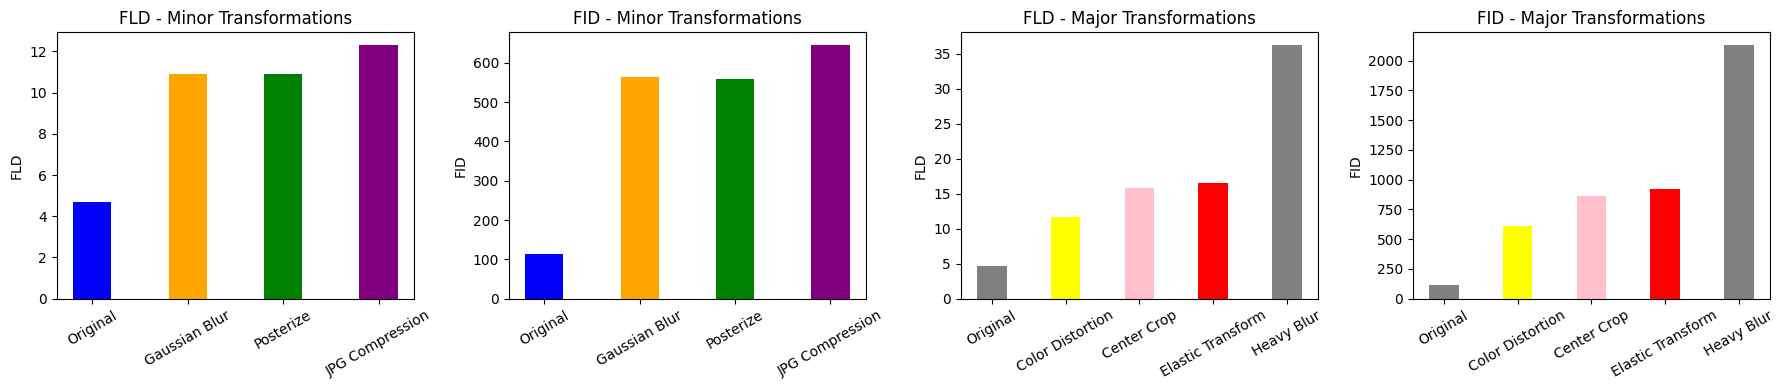

In [64]:
# Include the original results in the dictionaries
fid_scores["Original"] = fid_original_D1
fld_scores["Original"] = fld_original_D1

# Function to plot FID & FLD following the structure of the reference figure
def plot_fid_fld_results(fid_scores, fld_scores, minor_feats, major_feats):
    fig, axes = plt.subplots(1, 4, figsize=(18, 4))

    width = 0.4  # Width of bars

    # Separate minor and major transformation scores including the original
    minor_fid_scores = {"Original": fid_scores["Original"]}
    minor_fld_scores = {"Original": fld_scores["Original"]}
    major_fid_scores = {"Original": fid_scores["Original"]}
    major_fld_scores = {"Original": fld_scores["Original"]}

    for name, value in fid_scores.items():
        if name in minor_feats.keys():
            minor_fid_scores[name] = value
        elif name in major_feats.keys():
            major_fid_scores[name] = value

    for name, value in fld_scores.items():
        if name in minor_feats.keys():
            minor_fld_scores[name] = value
        elif name in major_feats.keys():
            major_fld_scores[name] = value

    # Ensure categories are correctly structured
    minor_categories = list(minor_fld_scores.keys())
    x_minor = np.arange(len(minor_categories))  # X locations for bars

    major_categories = list(major_fld_scores.keys())
    x_major = np.arange(len(major_categories))  # X locations for bars

    # Plot Minor FLD (1st Subplot)
    axes[0].bar(x_minor, minor_fld_scores.values(), width, color=['blue', 'orange', 'green', 'purple'])
    axes[0].set_title("FLD - Minor Transformations")
    axes[0].set_ylabel("FLD")
    axes[0].set_xticks(x_minor)
    axes[0].set_xticklabels(minor_categories, rotation=30)

    # Plot Minor FID (2nd Subplot)
    axes[1].bar(x_minor, minor_fid_scores.values(), width, color=['blue', 'orange', 'green', 'purple'])
    axes[1].set_title("FID - Minor Transformations")
    axes[1].set_ylabel("FID")
    axes[1].set_xticks(x_minor)
    axes[1].set_xticklabels(minor_categories, rotation=30)

    # Plot Major FLD (3rd Subplot)
    axes[2].bar(x_major, major_fld_scores.values(), width, color=['gray', 'yellow', 'pink', 'red'])
    axes[2].set_title("FLD - Major Transformations")
    axes[2].set_ylabel("FLD")
    axes[2].set_xticks(x_major)
    axes[2].set_xticklabels(major_categories, rotation=30)

    # Plot Major FID (4th Subplot)
    axes[3].bar(x_major, major_fid_scores.values(), width, color=['gray', 'yellow', 'pink', 'red'])
    axes[3].set_title("FID - Major Transformations")
    axes[3].set_ylabel("FID")
    axes[3].set_xticks(x_major)
    axes[3].set_xticklabels(major_categories, rotation=30)

    plt.tight_layout()
    plt.show()

# Call the function using user-defined variables
plot_fid_fld_results(fid_scores, fld_scores, minor_feats_D, major_feats_D)
